### This notebook goes over the process of obtaining the "normal form" of a simple quantum circuit

In [3]:
# Necessary imports 

import numpy as np
import pytket as tk
from pytket import passes as tkp
from pytket import circuit as tkc
from pytket.circuit.display import render_circuit_jupyter as print_circ
from pytket.qasm import circuit_from_qasm_str, circuit_to_qasm, circuit_from_qasm
import zipfile
import shutil
import os

In [4]:
def adding_registers(reading_file, modified_file):
    '''
    Counts the number of H gates h_count, adds a flag at
    each hadamard, and creates a quantum register and classical
    register of size h_count.
    '''
    h_count = 0
    h_qbit_list = []
    with open(reading_file, 'r') as file, open('temp.qasm', 'w') as new_file:
        for line in file:
            if line.strip().startswith('h q['):
                h_count += 1
                start_idx = line.find('[')
                end_idx = line.find(']')
                h_qbit_list.append(int(line[start_idx+1:end_idx]))
                new_file.write('//spotted\n')
            new_file.write(line)
    file.close()
    new_file.close()

    with open('temp.qasm', 'r') as file, open(modified_file, 'w') as new_file:
        for line in file:
            if line.strip().startswith('qreg'):
                new_file.write(line)
                new_file.write(f'qreg a[{h_count}];\n')
                new_file.write(f'creg ma[{h_count}];\n')
            else:
                new_file.write(line)


    return h_qbit_list

def hadamard_string(qbit_number, ancilla_number):
    '''
    Creates the two qubit blocks that
    substitute the hadamard gates
    '''

    return          f'h a[{ancilla_number}];\n' \
                    +   f's q[{qbit_number}];\n' \
                    +   f's a[{ancilla_number}];\n' \
                    +   f'cx q[{qbit_number}], a[{ancilla_number}];\n' \
                    +   f'sdg a[{ancilla_number}];\n' \
                    +   f'cx a[{ancilla_number}], q[{qbit_number}];\n' \
                    +   f'cx q[{qbit_number}], a[{ancilla_number}];\n' \
                    +   f'h a[{ancilla_number}];\n' \
                    +   f'measure a[{ancilla_number}] -> ma[{ancilla_number}];\n' \
                    +   f'if (ma[{ancilla_number}] == 1) x q[{qbit_number}];\n'

def add_h_blocks(old_file, modified_file, h_qbit_list):
    '''
    Substitutes the hadamard gates
    by the two qubit blocks defined in the paper
    '''
    flag = False
    ancilla_idx = 0

    with open(old_file, 'r') as file, open(modified_file, 'w') as new_file:
        for line in file:
            if flag:
                flag = False
                continue
            else:
                pass

            if line.strip().startswith('//spotted'):
                flag = True
                new_file.write(line)
                new_file.write(hadamard_string(h_qbit_list[ancilla_idx], ancilla_idx))
                ancilla_idx += 1
            else:
                new_file.write(line)



### Definition of circuit
We import the tof_3 circuit

In [5]:
c = tk.Circuit(5,5)
c.append(circuit_from_qasm(f'qasm_files/tof_3_modified.qasm'))
c.Measure(0,0)
c.Measure(1,1)
c.Measure(2,2)
c.Measure(3,3)
c.Measure(4,4)

# Define the necessary paths for gadgetizing the hadamards
test_path = 'non_gadgeted.qasm'
temp_path = 'flagged.qasm'
output_path = 'gadgeted.qasm'
circuit_to_qasm(c,test_path)
print_circ(c)

### Gadgetization of hadamards

In [4]:
h_q_list = adding_registers(test_path,temp_path)
add_h_blocks(temp_path, output_path, h_q_list)

c_gadgeted = circuit_from_qasm(output_path)
print_circ(c_gadgeted)

As we see, the gadgetized circuit has more qubits and gates due to the gadgetization

### Benchmarking
We now compare the outputs of both circuits

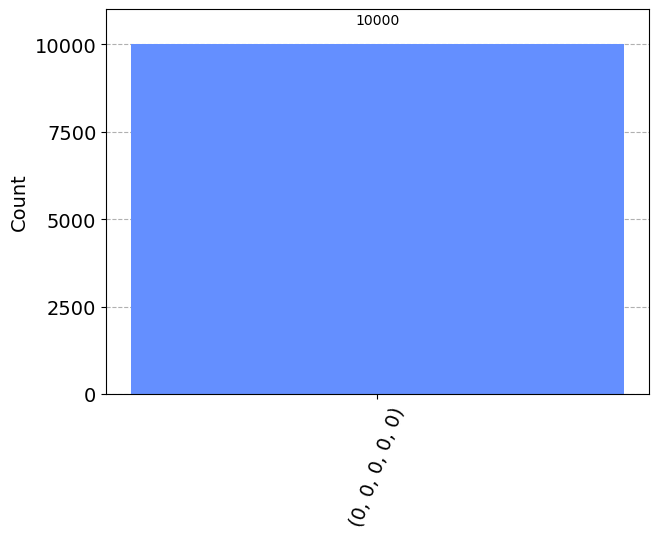

In [9]:
from pytket.extensions.qiskit import AerStateBackend
from qiskit.visualization import plot_histogram

backend = AerStateBackend()
handle = backend.process_circuit(c_gadgeted, n_shots=10000)
result = backend.get_result(handle)
all_counts = result.get_counts()
filtered_counts = {}
for output in all_counts:
    filtered_key = output[:5]  
    
    if filtered_key in filtered_counts:
        filtered_counts[filtered_key] += all_counts[output]
    else:
        filtered_counts[filtered_key] = all_counts[output]
plot_histogram(filtered_counts)

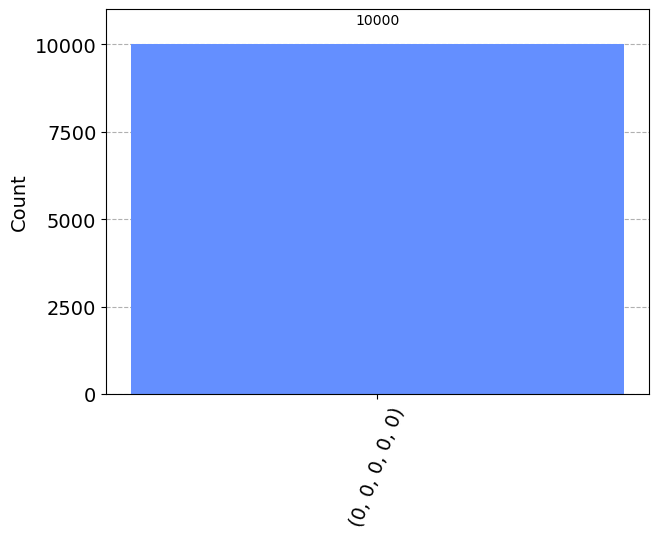

In [8]:
backend = AerStateBackend()
handle = backend.process_circuit(c, n_shots=10000)
result = backend.get_result(handle)
all_counts = result.get_counts()
filtered_counts = {}
for output in all_counts:
    filtered_key = output[:5]  
    
    if filtered_key in filtered_counts:
        filtered_counts[filtered_key] += all_counts[output]
    else:
        filtered_counts[filtered_key] = all_counts[output]
plot_histogram(filtered_counts)